# Market Sentiment vs Trader Behavior Analysis


In [2]:
# Install libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# Upload files
print("Please upload fear_greed_index.csv and historical_data.csv")
uploaded = files.upload()

# Load datasets
sent = pd.read_csv("fear_greed_index.csv")
trades = pd.read_csv("historical_data.csv")

👉 Please upload fear_greed_index.csv and historical_data.csv


Saving fear_greed_index.csv to fear_greed_index.csv
Saving historical_data.csv to historical_data.csv


In [3]:
# Data Preprocessing
# Sentiment
date_col_candidates = ["Date", "date", "day"]
for c in date_col_candidates:
    if c in sent.columns:
        sent['Date'] = pd.to_datetime(sent[c], errors='coerce')
        break
if 'Date' not in sent.columns:
    sent['Date'] = pd.to_datetime(sent.iloc[:,0], errors='coerce')
sent['Date'] = sent['Date'].dt.date
if 'Classification' not in sent.columns:
    for c in sent.columns:
        if 'class' in c.lower() or 'fear' in c.lower() or 'greed' in c.lower():
            sent['Classification'] = sent[c].astype(str)
            break
# Trades
time_candidates = ['time', 'Time', 'timestamp', 'datetime', 'Timestamp IST']
for c in time_candidates:
    if c in trades.columns:
        trades['time_parsed'] = pd.to_datetime(trades[c], errors='coerce')
        break
trades['date'] = trades['time_parsed'].dt.date
# Detect key columns
def find_col(df, keywords):
    for col in df.columns:
        if all(k in col.lower() for k in keywords):
            return col
    return None
exec_col = find_col(trades, ['price']) or "Execution Price"
pnl_col = find_col(trades, ['pnl']) or "Closed PnL"
size_col = find_col(trades, ['size'])  # may be None
lev_col = find_col(trades, ['lev'])    # may be None
# Numeric conversions
trades['execution_price'] = pd.to_numeric(trades.get(exec_col, np.nan), errors='coerce')
trades['closedPnL_num'] = pd.to_numeric(trades.get(pnl_col, np.nan), errors='coerce')
if size_col:
    trades['size_num'] = pd.to_numeric(trades[size_col], errors='coerce')
else:
    trades['size_num'] = np.nan
if lev_col:
    trades['leverage_num'] = pd.to_numeric(trades[lev_col], errors='coerce')
else:
    trades['leverage_num'] = np.nan
# Adjust size if side info exists
if 'side' in trades.columns:
    trades['side_norm'] = trades['side'].astype(str).str.lower()
    trades.loc[trades['side_norm'].isin(['sell','short','s']), 'size_num'] *= -1
# Derived features
trades['notional'] = trades['size_num'].abs() * trades['execution_price']
trades['pnl_pct'] = trades['closedPnL_num'] / trades['notional']

In [4]:
# Aggregation
agg_funcs = {
    'closedPnL_num': ['sum','mean','median'],
    'size_num': ['sum','mean','median'],
    'notional': ['sum','mean'],
    'pnl_pct': ['mean'],
    'leverage_num': ['mean'],
}
daily = trades.groupby('date').agg(agg_funcs)
daily.columns = ['_'.join(col).strip() for col in daily.columns.values]
daily = daily.reset_index().rename(columns={'date':'Date'})
daily['trade_count'] = trades.groupby('date').size().values
daily['win_rate'] = trades.groupby('date').apply(lambda g: (g['closedPnL_num']>0).mean()).values
daily['median_leverage'] = trades.groupby('date')['leverage_num'].median().values
# Merge with sentiment
sent_daily = sent[['Date','Classification']].drop_duplicates()
sent_daily['Date'] = pd.to_datetime(sent_daily['Date'], errors='coerce').dt.date
merged = pd.merge(daily, sent_daily, on='Date', how='left')
merged['sentiment_code'] = merged['Classification'].map({'Greed':1,'Fear':0})
merged.to_csv("summary_by_date.csv", index=False)

/tmp/ipython-input-4039464461.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily['win_rate'] = trades.groupby('date').apply(lambda g: (g['closedPnL_num']>0).mean()).values


In [5]:
# Results
print(" Analysis complete. File saved as summary_by_date.csv")
files.download("summary_by_date.csv")
# Summary by classification
summary_by_class = merged.groupby('Classification').agg({
    'closedPnL_num_sum':'sum',
    'closedPnL_num_mean':'mean',
    'size_num_sum':'sum',
    'notional_sum':'sum',
    'trade_count':'sum',
    'win_rate':'mean',
    'median_leverage':'mean',
    'pnl_pct_mean':'mean',
}).reset_index()
print("\nSummary by Sentiment Classification:")
display(summary_by_class)

 Analysis complete. File saved as summary_by_date.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Summary by Sentiment Classification:


,Classification,closedPnL_num_sum,closedPnL_num_mean,size_num_sum,notional_sum,trade_count,win_rate,median_leverage,pnl_pct_mean
0,Extreme Fear,4.399937e+03,8.951448,5.722062e+06,9.580240e+06,2326,0.307500,NaN,0.035727
1,Extreme Greed,1.156894e+06,46.834938,9.222549e+07,1.822376e+07,5621,0.319642,NaN,0.015219
2,Fear,1.779226e+06,56.312059,4.465631e+07,7.967439e+07,13869,0.348071,NaN,0.021870
3,Greed,6.096325e+05,29.148125,1.688861e+08,5.704582e+07,11292,0.362415,NaN,0.018190
4,Neutral,7.465674e+04,28.283112,4.883868e+07,1.193955e+07,2756,0.286719,NaN,0.005699


In [7]:
summary_by_class.to_csv("summary_by_class.csv", index=False)
files.download("summary_by_class.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

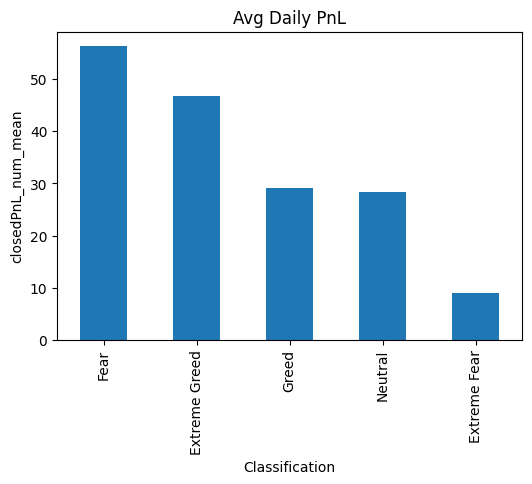

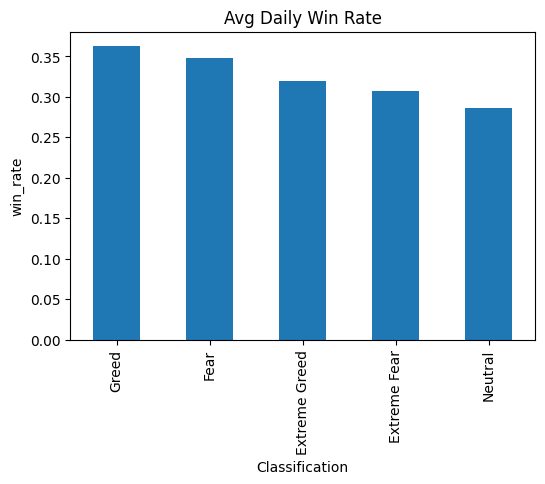

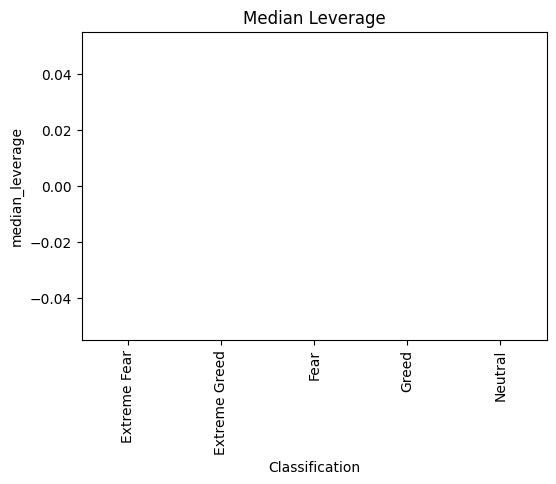

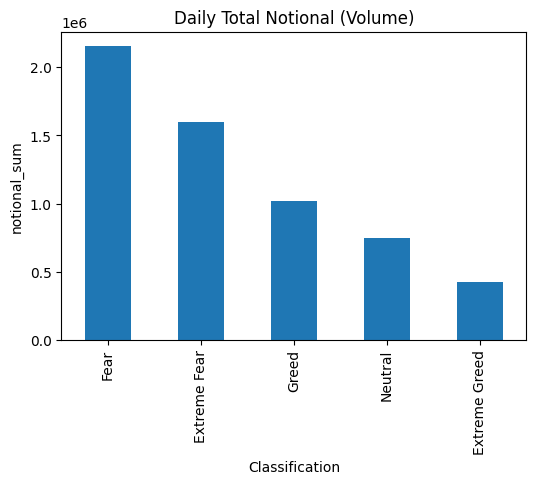

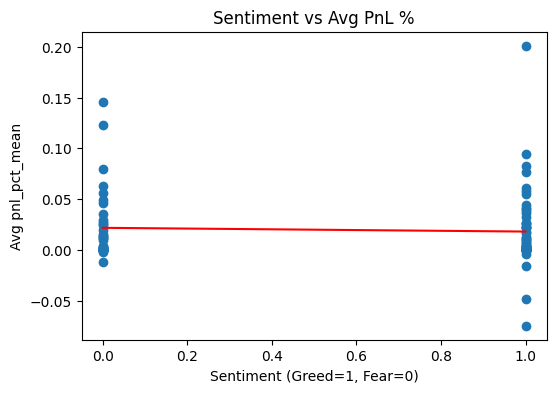

In [6]:
# Visualizations
plot_df = merged.dropna(subset=['Classification'])
metrics = {
    'closedPnL_num_mean': 'Avg Daily PnL',
    'win_rate': 'Avg Daily Win Rate',
    'median_leverage': 'Median Leverage',
    'notional_sum': 'Daily Total Notional (Volume)'
}
for col, title in metrics.items():
    agg = plot_df.groupby('Classification')[col].mean().sort_values(ascending=False)
    plt.figure(figsize=(6,4))
    agg.plot(kind='bar')
    plt.title(title)
    plt.ylabel(col)
    plt.show()
plt.figure(figsize=(6,4))
plt.scatter(plot_df['sentiment_code'], plot_df['pnl_pct_mean'])
plt.xlabel('Sentiment (Greed=1, Fear=0)')
plt.ylabel('Avg pnl_pct_mean')
plt.title('Sentiment vs Avg PnL %')
mask = (~plot_df['sentiment_code'].isna()) & (~plot_df['pnl_pct_mean'].isna())
if mask.sum() > 1:
    m, b = np.polyfit(plot_df.loc[mask,'sentiment_code'], plot_df.loc[mask,'pnl_pct_mean'], 1)
    xs = np.linspace(0,1,10)
    plt.plot(xs, m*xs + b, color='red')
plt.show()